In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import load_data as ld
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models

print(tf.__version__)

2.6.0


In [2]:
sst_train, ssh_train, nino34_train = ld.load_train("../data/train_data", op_len=13, with_obs=True,out_put_one=True,load0_func=ld.load_spmonth)
ssh_train.shape,ssh_train.shape,nino34_train.shape

../data/train_data/ACCESS-CM2
ACCESS-CM2 Ini_data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
../data/train_data/CanESM2
CanESM2 Ini_data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
../data/train_data/CCSM4
CCSM4 Ini_data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
../data/train_data/CESM1-CAM5
CESM1-CAM5 Ini_data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
../data/train_data/CESM2
CESM2 Ini_data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
../data/train_data/CMCC-CESM
CMCC-CESM Ini_data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
../data/train_data/CMCC-CM
CMCC-CM Ini_data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
../data/train_data/CMCC-CMS
CMCC-CMS Ini_data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
../data/train_data/CNRM-CM5
CNRM-CM5 Ini_data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
../data/train_data/CNRM-CM6-1
CNRM-CM6-1 Ini_data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
../data/train_data/CSIRO-Mk3-6-0
CSIRO-Mk3-6-0 Ini_data_shape: (1870, 24, 72) (1870, 24, 72)

((3574, 24, 72, 3), (3574, 24, 72, 3), (3574,))

In [3]:
sst_var, ssh_var, nino34_var = ld.load_spmonth("../data/var_data", op_len=13,out_put_one=True,label="Var")
sst_var.shape,ssh_var.shape,nino34_var.shape

../data/var_data
var_data Ini_data_shape: (479, 24, 72) (479, 24, 72) (479,)


((38, 24, 72, 3), (38, 24, 72, 3), (38,))

In [4]:
sst_std = sst_train.std()
ssh_std = ssh_train.std()
nino34_std = nino34_train.std()
print(sst_std, ssh_std, nino34_std)
sst_train, ssh_train, nino34_train = sst_train / sst_std, ssh_train / ssh_std, nino34_train / nino34_std
# obs_sst_train, obs_ssh_train, obs_nino34_train = obs_sst_train / sst_std, obs_ssh_train / ssh_std, obs_nino34_train / nino34_std
sst_var, ssh_var, nino34_var = sst_var / sst_std, ssh_var / ssh_std, nino34_var / nino34_std

0.52518463 0.03429232 1.1402133


In [5]:
ip_var = np.concatenate([sst_var, ssh_var], axis=3)
ip_train = np.concatenate([sst_train, ssh_train], axis=3)
# obs_ip_train = np.concatenate([obs_sst_train, obs_ssh_train], axis=3)
# ip_train.shape, ip_var.shape , obs_sst_train.shape
ip_train.shape, ip_var.shape

((3574, 24, 72, 6), (38, 24, 72, 6))

In [6]:
True in np.isnan(ip_train)

False

In [7]:
nino34_train.shape

(3574,)

In [8]:
# shuffle
ip_train, nino34_train = shuffle(ip_train, nino34_train)
# obs_sst_train , obs_nino34_train = shuffle(obs_sst_train , obs_nino34_train)

In [19]:
model = models.Sequential(name="ENSO")
model.add(layers.Conv2D(30, (4, 8), activation="tanh", padding="same", input_shape=ip_train.shape[1:]))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(30, (4, 8), activation="tanh", padding="same"))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(30, (4, 8), activation="tanh", padding="same"))
model.add(layers.Flatten())
model.add(layers.Dense(30,activation="tanh"))
model.add(layers.Dense(1))
model.summary()

Model: "ENSO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 72, 30)        5790      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 36, 30)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 36, 30)        28830     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 18, 30)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 18, 30)         28830     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3240)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                97230  

In [25]:
# Pre-train with Model Data
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)
model.compile(optimizer=keras.optimizers.SGD(), loss="mse")
hist = model.fit(ip_train, nino34_train, validation_data=(ip_var, nino34_var), epochs=15, batch_size=1,callbacks=[early_stopping, reduce_lr])
model.save("../data/model/exp1_pretrain_op1_sp")

Epoch 1/15
3574/3574 [==============================] - 17s 5ms/step - loss: 1.0749 - val_loss: 0.9150
Epoch 2/15
3574/3574 [==============================] - 16s 5ms/step - loss: 1.0129 - val_loss: 1.0385
Epoch 3/15
3574/3574 [==============================] - 16s 5ms/step - loss: 1.0384 - val_loss: 1.0921
Epoch 4/15
3574/3574 [==============================] - 16s 5ms/step - loss: 1.1346 - val_loss: 1.1240
Epoch 5/15
3574/3574 [==============================] - 16s 5ms/step - loss: 0.7535 - val_loss: 0.6745
Epoch 6/15
3574/3574 [==============================] - 16s 5ms/step - loss: 0.7047 - val_loss: 0.7549
Epoch 7/15
3574/3574 [==============================] - 16s 5ms/step - loss: 0.6712 - val_loss: 0.6921
Epoch 8/15
3574/3574 [==============================] - 16s 5ms/step - loss: 0.6477 - val_loss: 0.5830
Epoch 9/15
3574/3574 [==============================] - 16s 5ms/step - loss: 0.6214 - val_loss: 0.6155
Epoch 10/15
3574/3574 [==============================] - 16s 5ms/step - l

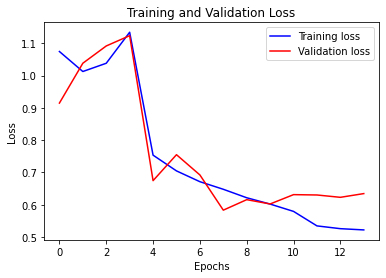

In [26]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    # plt.savefig('../pic/train_prog.png', dpi=300)
    plt.show()


visualize_loss(hist, "Training and Validation Loss")

In [27]:
pre_nino = model.predict(ip_var)
pre_nino.shape, nino34_var.shape

((38, 1), (38,))

In [28]:
import scipy.stats as sts

# corr_ls = []
# for i in range(17):
corr, _ = sts.pearsonr(pre_nino[:,0], nino34_var)
corr
#     corr_ls.append(corr)
# plt.plot(np.arange(1, 18), corr_ls, "o-", color="blue")
# plt.xlabel("lead time (month)")
# plt.ylabel("correlation skill")
# plt.axhline(0.5, color="k", linestyle=":")
# plt.savefig("../pic/corr_skill.png")

0.5276905847782951

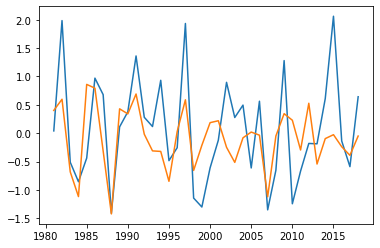

In [31]:
time = np.arange(1981,2019)
plt.plot(np.arange(1981,2019),nino34_var)
plt.plot(np.arange(1981,2019),pre_nino[:,0])


In [35]:
np.arange(1981,2019)[7],pre_nino[:,0][7],nino34_var[7]

(1988, -1.4238479, -1.4127866)

In [38]:
np.save("../data/1988_lanina_ip_sp",ip_var)